# Fitness Classifiction Data

In [ ]:
# Importing Libraries
%pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
%matplotlib inline

In [ ]:
# Loading dataset
df = pd.read_csv('/content/drive/My Drive/fitness_class_2212.csv')  # Replace with your file path

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (1500, 8)

First 5 Rows:


,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


##Missing data

In [ ]:
# Check for missing data
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64


In [ ]:
# Handling missing data
# The missing data can be handle by dropping instances with missing values or imputation

# 1. Drop rows with missing values
df = df.dropna()

# 2. Impute missing values (alternetive)
# imputer = SimpleImputer(strategy='mean')
# df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

##Exploratory Data Analysis

In [ ]:
df.describe()

,booking_id,months_as_member,weight,attended
count,1480.000000,1480.000000,1480.000000,1480.000000
mean,749.621622,15.659459,82.610378,0.303378
std,433.758225,12.971138,12.765859,0.459873
min,1.000000,1.000000,55.410000,0.000000
25%,374.750000,8.000000,73.490000,0.000000
50%,749.500000,12.000000,80.760000,0.000000
75%,1126.250000,19.000000,89.520000,1.000000
max,1500.000000,148.000000,170.520000,1.000000


In [ ]:
# Unique values in the target variable
df['attended'].unique()

array([0, 1])

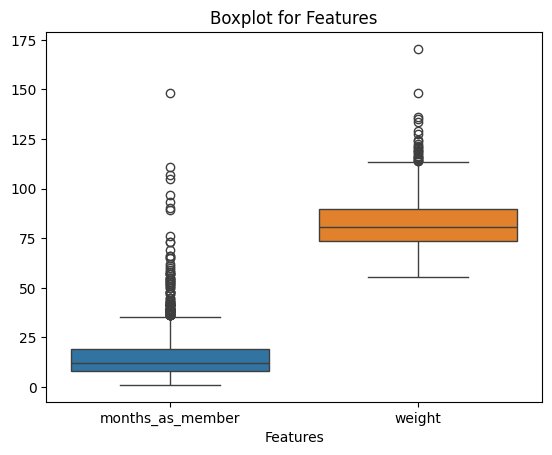

In [ ]:
# Boxplot of the numeric features
sns.boxplot(data=df.drop(['booking_id','attended'], axis=1))   # Removed the booking ID and attented variables
plt.title('Boxplot for Features')
plt.xlabel('Features')
plt.show()

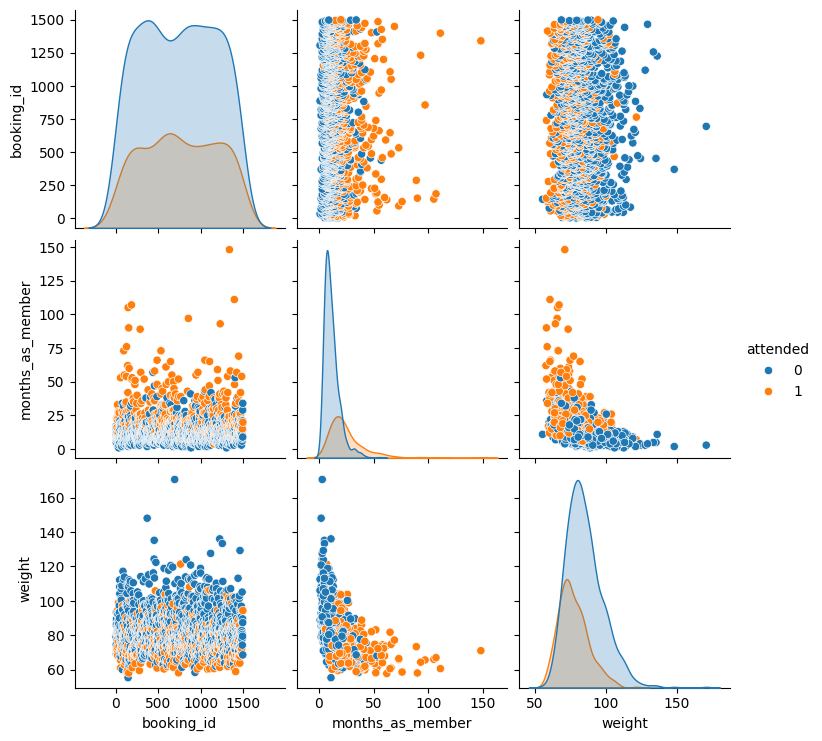

In [ ]:
# Pairplot using the target variable as the hue
sns.pairplot(data=df, hue='attended')

## Preprocessing

### Label encoding

In [ ]:
# Label encoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

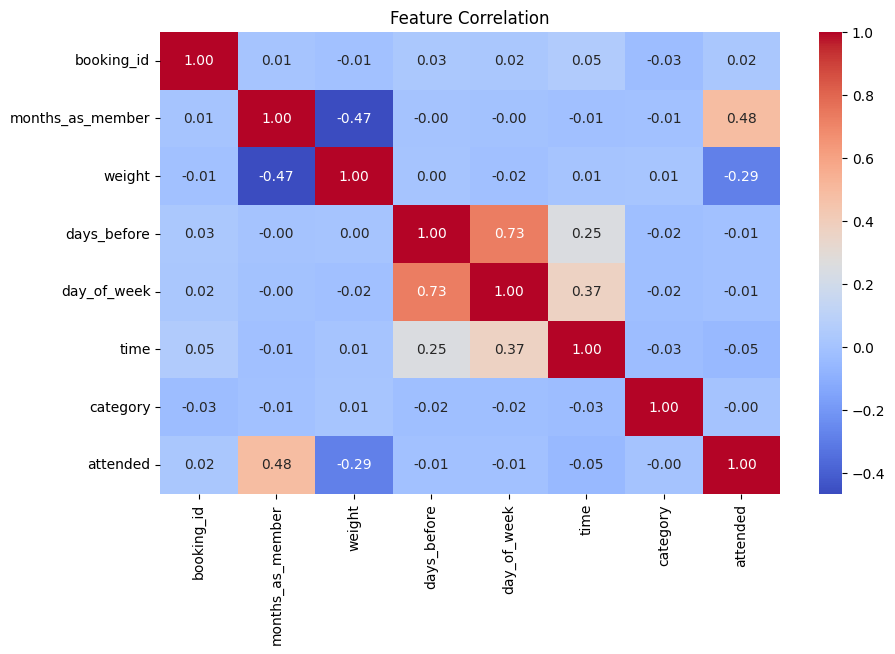

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

### Split Features and Test-train split

In [ ]:
# Split features and target
X = df.drop('attended', axis=1)  # Replace 'Attendance' with your target column name
y = df['attended']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling Data

In [ ]:
# Feature scaling using standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Balancing Dataset

In [ ]:
# Balancing the Dataset (SMOTE: Oversampling using imblearn library)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


### Logistic Regression

In [ ]:
#Logistic Regression
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_lr_balanced = lr_balanced.predict(X_test_scaled)

print("\nLogistic Regression Performance (With Balancing):")
print(classification_report(y_test, y_pred_lr_balanced))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_balanced))


Logistic Regression Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       308
           1       0.61      0.65      0.63       136

    accuracy                           0.76       444
   macro avg       0.72      0.73      0.73       444
weighted avg       0.77      0.76      0.77       444

Confusion Matrix:
[[251  57]
 [ 48  88]]


In [ ]:
#Hyperparameter Tuning (Logistic Regression)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization (l1 for Lasso, l2 for Ridge)
    'solver': ['liblinear', 'saga']  # solvers that support l1 and l2 penalties

}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5)
grid_search_lr.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Logistic Regression:")
print(grid_search_lr.best_params_)

# Evaluate tuned Logistic Regression Model
best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_scaled)

metrics = []

def Append_Metrics(metric_holder,model_name,y_pred):
  metric_holder.append({
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test,y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            })


Append_Metrics(metrics,'Logistic_Regression',y_pred_best_lr)

print("\nTuned Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_best_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lr))

print(metrics)


Best Parameters for Logistic Regression:
{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

Tuned Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       308
           1       0.60      0.63      0.62       136

    accuracy                           0.76       444
   macro avg       0.72      0.72      0.72       444
weighted avg       0.76      0.76      0.76       444

Confusion Matrix:
[[251  57]
 [ 50  86]]
[{'Model': 'Logistic_Regression', 'Accuracy': 0.759009009009009, 'Precision': 0.6013986013986014, 'Recall': 0.6323529411764706, 'F1': 0.6164874551971327}]


In [ ]:
#Cross-Validation (Logistic Regression)
cv_scores_lr = cross_val_score(best_lr, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nLogistic Regression Cross-Validation Scores:", cv_scores_lr)
print("Mean CV Accuracy:", cv_scores_lr.mean())


Logistic Regression Cross-Validation Scores: [0.73103448 0.80276817 0.74394464 0.76124567 0.7716263 ]
Mean CV Accuracy: 0.7621238515690252


### Random Forest

In [ ]:
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_rf_balanced = rf_balanced.predict(X_test_scaled)

print("\nRandom Forest Performance (With Balancing):")
print(classification_report(y_test, y_pred_rf_balanced))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_balanced))


Random Forest Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       308
           1       0.58      0.61      0.59       136

    accuracy                           0.74       444
   macro avg       0.70      0.71      0.70       444
weighted avg       0.75      0.74      0.75       444

Confusion Matrix:
[[247  61]
 [ 53  83]]


In [ ]:
#Hyperparameter Tuning (Random Forest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate tuned Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

Append_Metrics(metrics,'Random_Forest',y_pred_best_rf)

print("\nTuned Random Forest Performance:")
print(classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))


Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       308
           1       0.59      0.60      0.59       136

    accuracy                           0.75       444
   macro avg       0.71      0.71      0.71       444
weighted avg       0.75      0.75      0.75       444

Confusion Matrix:
[[252  56]
 [ 55  81]]


In [ ]:
#Cross-Validation (Random Forest)
cv_scores_rf = cross_val_score(best_rf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Scores:", cv_scores_rf)
print("Mean CV Accuracy:", cv_scores_rf.mean())


Random Forest Cross-Validation Scores: [0.73103448 0.7716263  0.83044983 0.8200692  0.87543253]
Mean CV Accuracy: 0.8057224674859802


### Gradient Boosting Trees (GBT)

In [ ]:
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train_balanced, y_train_balanced)
y_pred_gbt = gbt.predict(X_test_scaled)

print("\nGradient Boosting Trees Performance:")
print(classification_report(y_test, y_pred_gbt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbt))


Gradient Boosting Trees Performance:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       308
           1       0.57      0.60      0.58       136

    accuracy                           0.74       444
   macro avg       0.69      0.70      0.69       444
weighted avg       0.74      0.74      0.74       444

Confusion Matrix:
[[246  62]
 [ 55  81]]


In [ ]:
#Hyperparameter Tuning (Gradient Boosting Trees)
param_grid_gbt = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_gbt = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbt, cv=5)
grid_search_gbt.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Gradient Boosting Trees:")
print(grid_search_gbt.best_params_)

# Evaluate tuned Gradient Boosting Trees
best_gbt = grid_search_gbt.best_estimator_
y_pred_best_gbt = best_gbt.predict(X_test_scaled)

Append_Metrics(metrics,'Gradient Boosting Trees',y_pred_best_gbt)
metrics_df = pd.DataFrame(metrics)   # Create a Dataframe of the metrics of the models

print("\nTuned Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_best_gbt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_gbt))


Best Parameters for Gradient Boosting Trees:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Tuned Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       308
           1       0.58      0.54      0.56       136

    accuracy                           0.74       444
   macro avg       0.69      0.68      0.69       444
weighted avg       0.73      0.74      0.74       444

Confusion Matrix:
[[255  53]
 [ 63  73]]


In [ ]:
#Cross-Validation (Random Forest)
cv_scores_gbt = cross_val_score(best_gbt, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nGradient Boosting Trees Cross-Validation Scores:", cv_scores_gbt)
print("Mean CV Accuracy:", cv_scores_gbt.mean())


Gradient Boosting Trees Cross-Validation Scores: [0.69310345 0.75086505 0.82698962 0.84775087 0.88235294]
Mean CV Accuracy: 0.8002123851569024


### Comparing Model Performance

#### Confusion Matrices

Text(0.5, 1.0, 'Gradient Boosting Trees')

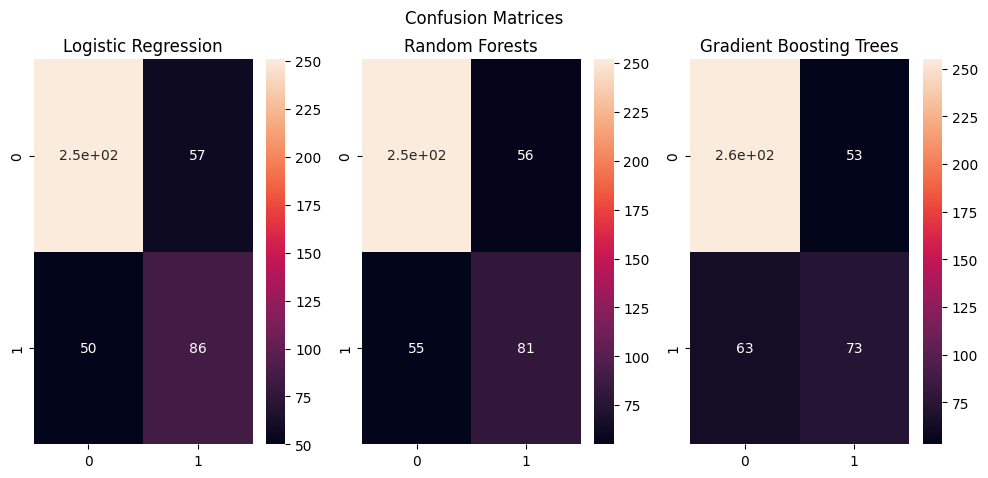

In [ ]:
from sklearn.metrics import confusion_matrix

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
fig.suptitle('Confusion Matrices')

# Logistic Regression
cm = confusion_matrix(y_test,y_pred_best_lr)
sns.heatmap(cm,annot=True, ax=ax1)
ax1.set_title('Logistic Regression')

# Random Forests
cm = confusion_matrix(y_test,y_pred_best_rf)
sns.heatmap(cm,annot=True, ax=ax2)
ax2.set_title('Random Forests')

# Gradient Boosting Trees
cm = confusion_matrix(y_test,y_pred_best_gbt)
sns.heatmap(cm,annot=True, ax=ax3)
ax3.set_title('Gradient Boosting Trees')

### Barchart

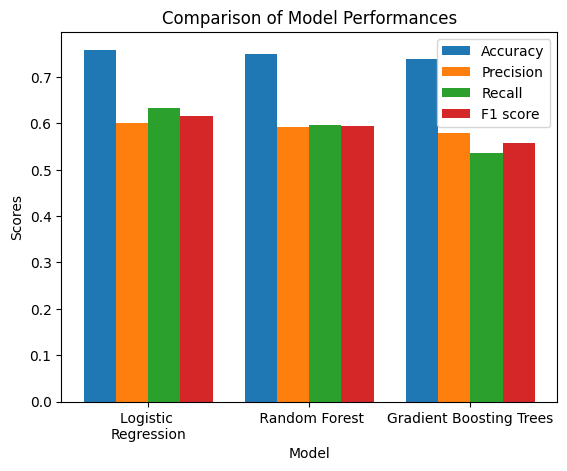

In [ ]:
# Bar Chart of Performance Metrics
positions = np.arange(len(metrics_df))
bar_width = 0.2  # Reduced width to fit 4 bars


# Plot bars with appropriate spacing
plt.bar(positions - 1.5 * bar_width, metrics_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(positions - 0.5 * bar_width, metrics_df['Precision'], width=bar_width, label='Precision')
plt.bar(positions + 0.5 * bar_width, metrics_df['Recall'], width=bar_width, label='Recall')
plt.bar(positions + 1.5 * bar_width, metrics_df['F1'], width=bar_width, label='F1 score')


# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Model Performances')

# Adding legend and xticks
plt.legend()
plt.xticks(positions, ['Logistic \nRegression', ' Random Forest', 'Gradient Boosting Trees'])
plt.show()

### Bias-Variance Tradeoff (Learning Curves)

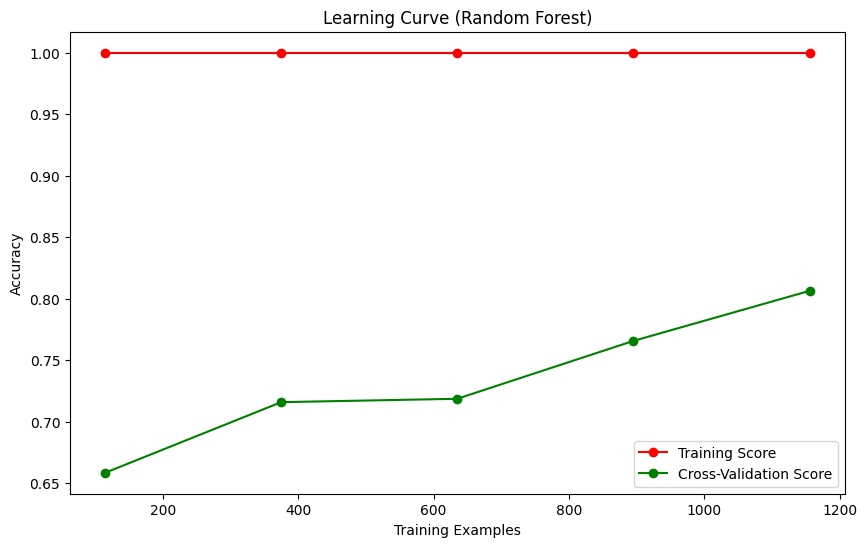

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 669, in fit
    y = self._encode_y(y=y, sample_weig

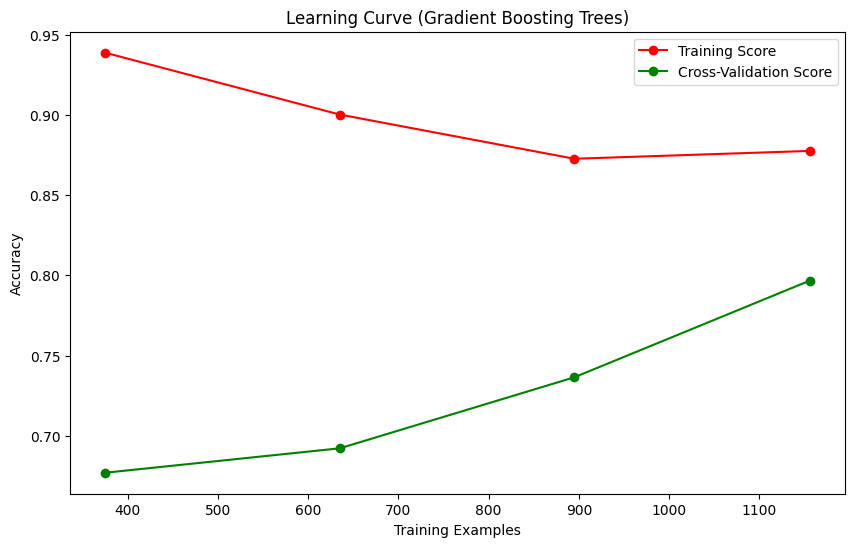

In [ ]:
from sklearn.model_selection import learning_curve

# Function to plot the learning curve for the input estimator
def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

# Plot learning curve for Random Forest
plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train_balanced, y_train_balanced)

# Plot learning curve for Gradient Boosting Trees
plot_learning_curve(gbt, "Learning Curve (Gradient Boosting Trees)", X_train_balanced, y_train_balanced)
